In [2]:
import torch
import torchvision
import time
import random
import math
import json
import copy

from PIL import Image, ImageFont, ImageDraw

In [3]:
alphabet = ['*','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
random.seed(100)
alphabetColors = [(random.randrange(256),random.randrange(256),random.randrange(256)) for i in alphabet]
def displayCoords(image, coords, labels):
    font = ImageFont.truetype("meiryo.ttc", 20)
    imageCopy = image.copy()
    draw = ImageDraw.Draw(imageCopy)
    for i in range(len(coords)):
        coord = coords[i]
        label = labels[i]
        x1 = coord[0]
        y1 = coord[1]
        x2 = coord[2]
        y2 = coord[3]
        color = alphabetColors[label]
        
        draw.rectangle([x1,y1,x2,y2], outline=color, width=2)
        draw.text((x1+2,y1), alphabet[label], color, font=font)
        
    display(imageCopy)

def displayGroups(image, results, levels, showBoxNumber=False):
    font = ImageFont.truetype("meiryo.ttc", 20)
    imageCopy = image.copy()
    draw = ImageDraw.Draw(imageCopy)
    
    index = 0
    for level in levels:
        for group in results['groups'][level]:
            for i in group:
                
                coord = results['boxes'][i]
                label = results['labels'][i]
                x1 = coord[0]
                y1 = coord[1]
                x2 = coord[2]
                y2 = coord[3]
                color = alphabetColors[label]
                boxNumber = str(i)*int(showBoxNumber)

                index+=1
                draw.rectangle([x1,y1,x2,y2], outline=color, width=2)
                draw.text((x1+2,y1), alphabet[label], color, font=font)
                draw.text((x1+2,y1-20), boxNumber, color, font=font)
        
    display(imageCopy)
    
def displayLines(image, results, lines, indicesLines=None, showBoxNumber=False):
    font = ImageFont.truetype("meiryo.ttc", 20)
    imageCopy = image.copy()
    draw = ImageDraw.Draw(imageCopy)
    
    if indicesLines==None:
        indicesLines = [i for i in range(len(lines))]
    
    index = 0
    for indexLine in indicesLines:
        for letter in lines[indexLine]:
            
            coord = results['boxes'][letter]
            label = results['labels'][letter]
            x1 = coord[0]
            y1 = coord[1]
            x2 = coord[2]
            y2 = coord[3]
            color = alphabetColors[label]
            boxNumber = str(letter)*int(showBoxNumber)

            index+=1
            draw.rectangle([x1,y1,x2,y2], outline=color, width=2)
            draw.text((x1+2,y1), alphabet[label], color, font=font)
            draw.text((x1+2,y1-20), boxNumber, color, font=font)
        
    display(imageCopy)
    
loadingStrings = [' ','▏','▎','▍','▌','▋','▊','▉','█']
def printLoadingBar(percentage:float, length:int, startTime:float):
    if percentage==0.0:
        print(" " + "_"*length)
    
    nbFilled = max(0, min(length, int(length*percentage)))
    remainder = length*percentage - int(length*percentage)
    strRemainder = loadingStrings[int(remainder*len(loadingStrings))]
    strPercentage = "{0:.2f}%".format(100*percentage) 
    isBarFull = int(nbFilled!=length)
    bar = "▕" + "█"*(nbFilled) + isBarFull*strRemainder + " "*(length-nbFilled-1) + "▏" + strPercentage
    
    ellapsedTime = time.time() - startTime
    eta = 0.0 if percentage==0.0 else ellapsedTime*((1-percentage)/percentage)
    isMinute = int(int(eta)>=60)
    isZero = int(percentage<0.99999)
    strEta = isMinute*"{0}m".format(int(eta)//60) + isZero*"{0}s".format(int(eta)%60)
    
    buffer = " "*(length+20)
    
    print(buffer,end="\r")
    print(bar + " " + strEta,end="\r")

In [4]:
torch.no_grad()

evalModel = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(
    weights=None,
    num_classes=27, # alphabet+background
    box_detections_per_img=2000,
    
    rpn_pre_nms_top_n_train=2000, #number of proposals to keep before applying NMS during training
    rpn_pre_nms_top_n_test=2000, #number of proposals to keep before applying NMS during testing
    rpn_post_nms_top_n_train=2000, #number of proposals to keep after applying NMS during training
    rpn_post_nms_top_n_test=2000, #number of proposals to keep after applying NMS during testing
    
    rpn_batch_size_per_image=32768, #number of anchors
    
    #box_fg_iou_thresh=0.2, Not useful here, but could be used in training
    #box_bg_iou_thresh=0.2,
    
    box_score_thresh=0.3
)
evalModel.eval()
#evalModel.load_state_dict(torch.load("./Models/SoulGlyph_Mobile_Model_V18.pth"))
#evalModel.load_state_dict(torch.load("./Models/SoulGlyph_Mobile_Model_V20_font100-240.pth")) #Works
evalModel.load_state_dict(torch.load("./Models/SoulGlyph_Mobile_Model_V21_font100-240.pth"))


<All keys matched successfully>

In [5]:
def sortResults(result):
    
    indices = result['scores'].argsort(dim=0, descending=True)
    indices4 = indices.repeat(4,1).transpose(1,0)
    
    result2 = {'groups':[], 'neighbors':[]}
    
    result2['boxes'] = result['boxes'].gather(index=indices4,dim=0)
    result2['labels'] = result['labels'].gather(index=indices,dim=0)
    result2['scores'] = result['scores'].gather(index=indices,dim=0)
    
    indicesList = indices.tolist()
    indicesReverse = {str(indicesList[i]):i for i in range(len(indicesList))}
    for level in range(len(result['groups'])):
        result2['groups'].append([])
        for group in result['groups'][level]:
            #result2['groups'].append([indicesList[i] for i in group])
            result2['groups'][level].append(sorted([indicesReverse[str(i)] for i in group]))
        
    """ Neighbors don't exist yet
    for neighborsGroup in result['neighbors']:
        #result2['neighbors'].append([indicesList[i] for i in neighborsGroup])
        result2['neighbors'].append(sorted([indicesReverse[str(i)] for i in neighborsGroup]))
    """
        
    return result2

def vizTensor(tensor):
    T = torchvision.transforms.ToPILImage()
    display(T(tensor))
    
def rotateBox(box:list, angle:float, center:tuple) -> list:
    angleRad = math.pi*angle/180
    
    x1,y1,x2,y2 = box
    x1=x1-center[0]
    x2=x2-center[0]
    y1=-(y1-center[1])
    y2=-(y2-center[1])
    
    cos=math.cos(angleRad)
    sin=math.sin(angleRad)
    newXs = [
        x1*cos-y1*sin,
        x2*cos-y1*sin,
        x1*cos-y2*sin,
        x2*cos-y2*sin
    ]
    
    newYs = [
        -(x1*sin+y1*cos),
        -(x2*sin+y1*cos),
        -(x1*sin+y2*cos),
        -(x2*sin+y2*cos)
    ]
    """
    tl = (x1*cos-y1*sin, x1*sin+y1*cos)
    tr = (x2*cos-y1*sin, x2*sin+y1*cos)
    bl = (x1*cos-y2*sin, x1*sin+y2*cos)
    br = (x2*cos-y2*sin, x2*sin+y2*cos)
    """
    return [min(newXs)+center[0], min(newYs)+center[1], max(newXs)+center[0], max(newYs)+center[1]]

def filterResults(result, min_score):
    i = 0
    while i < len(result['scores']) and result['scores'][i] > min_score:
        i+=1
        
    result['boxes'] = result['boxes'][:i]
    result['labels'] = result['labels'][:i]
    result['scores'] = result['scores'][:i]
    
    for level in range(len(result['groups'])):
        for j,group in enumerate(result['groups'][level]):
            result['groups'][level][j] = [n for n in group if n<i]
    
    """ Neighbors don't exist yet
    for j,neighborsGroup in enumerate(result['neighbors']):
        result['neighbors'][j] = [n for n in neighborsGroup if n<i]
    """

def resultsToLists(result):
    result['boxes'] = result['boxes'].tolist()
    result['labels'] = result['labels'].tolist()
    result['scores'] = result['scores'].tolist()
    
def computeNeighbors(result,dims): # CHANGE NEIGHBORHOOD FOR levelNeigh
    
    nGroups = sum([len(x) for x in result['groups']])
    result['neighbors'] = [[] for i in range(nGroups)] #create neighbors for each group of all levels
    
    #result['neighbors'][nGroups].extend(result['groups'][nGroups])
    neighborhood = 0
    levelNeigh = 0
    for level in range(len(dims)):
        nX,nY = dims[level]
        
        for iGroup in range(0,(nX*nY)):
            #print(len(result['groups'][level][n]))
            #print("n={0}".format(iGroup))
            result['neighbors'][iGroup+neighborhood].extend(result['groups'][level][iGroup])
            
        removeOverlaps(result, neighborhood, neighborhood+len(result['groups'][level]))
        print("")
        for dx in [-1,0,1]:     #INVERT X,Y AND DX,DY LOOPS, AND FOR EVERY DX COMBINATION, REMOVE OVERLAPS
            for dy in [-1,0,1]:
                for x in range(nX):
                    for y in range(nY):
                        newX = x+dx
                        newY = y+dy
                        group2 = (newX*nY+newY)
                        
                        group1 = (x*nY+y)
                        
                        if 0<=newX<nX and 0<=newY<nY and not (dx == 0 == dy):
                            #result['neighbors'][neighborhood].extend(result['groups'][level][group2])
                            result['neighbors'][levelNeigh+group1].extend(result['groups'][level][group2])
                neighborhood+=1
            removeOverlaps(result, levelNeigh, levelNeigh+(nX*nY)) #PYTORCH BROADCAST THE WHOLE BOOLEAN COMPARISON ?!?!!?!?
        
        #removeOverlaps(result, neighborhood-len(result['groups'][level]), neighborhood)
        print("")
        
        level2 = level-1
        nX2,nY2 = (0,0) if (level2<0) else dims[level2]
        neighborhood2 = neighborhood-(nX*nY)
        
        #Add neighborhoods of the previous level
        if level2 >= 0:
            print("{0}x{1}".format(nX,nY))
            for x in range(nX):
                for y in range(nY):           # NEED TO ADD NEIGHBORS FROM ADJACENT (3x3) LEVEL2 TILES
                    #print("neigh2={0}".format(neighborhood2))
                    newX = 2*x + 1
                    newY = 2*y + 1

                    correspondingNeighborhood = neighborhood - (nX*nY) - (nX2*nY2 - (newX*nY2+newY))
                    if 0<=newX<nX2 and 0<=newY<nY2:
                        result['neighbors'][neighborhood2].extend(result['neighbors'][correspondingNeighborhood])

                    neighborhood2+=1
                    
            removeOverlaps(result, neighborhood2-len(result['groups'][level]), neighborhood2)
            print("")
        
        levelNeigh+=nX*nY
    

def applySubPicture(model,tensor,x1=0,y1=0,w1=None,h1=None,w2=None,h2=None,sampleSize=(160,160),upscaleMaxSize=(800,800)):
    if w1 is None or w2 is None or h1 is None or h2 is None:
        h1,w1 = tensor.shape[-2:]
        h2,w2 = tensor.shape[-2:]
    
    pad = torch.nn.ZeroPad2d((0,sampleSize[0]-w1,0,sampleSize[1]-h1))
    #resize = torchvision.transforms.Resize(size=(h2,w2), interpolation=torchvision.transforms.InterpolationMode.BICUBIC)
    resize = torchvision.transforms.Resize(size=upscaleMaxSize, interpolation=torchvision.transforms.InterpolationMode.BICUBIC)
    
    xmod = w1/w2
    ymod = h1/h2
    
    cropped_tensor = tensor[:,y1:y1+h1,x1:x1+w1]
    paddedTensor = pad(cropped_tensor)
    tensor_resized = resize(paddedTensor)
    
    """
    print("-------------")
    print("(x1,y1)=({0},{1})".format(x1,y1))
    print("(w1,h1)=({0},{1})".format(w1,h1))
    print(cropped_tensor.shape[1:])
    print(tensor_resized.shape[1:])
    vizTensor(tensor_resized)
    """
    
    result = model([tensor_resized])
    for i in range(len(result[0]['boxes'])):
        result[0]['boxes'][i][0] = result[0]['boxes'][i][0]*xmod + x1
        result[0]['boxes'][i][1] = result[0]['boxes'][i][1]*ymod + y1
        result[0]['boxes'][i][2] = result[0]['boxes'][i][2]*xmod + x1
        result[0]['boxes'][i][3] = result[0]['boxes'][i][3]*ymod + y1
    
    return result

def getOverlap(rect1, rect2) -> float:
    
    x1,y1,x1_,y1_ = rect1
    x2,y2,x2_,y2_ = rect2
    
    dx = min(x1_,x2_)-max(x1,x2)
    dy = min(y1_,y2_)-max(y1,y2)
    
    isOverlapp = int(dx>0 and dy>0)
    area = isOverlapp*dx*dy
    
    return area

def getArea(rect) -> float:
    return (rect[2]-rect[0])*(rect[3]-rect[1])

def removeOverlaps(results, startNeighborhood=0, endNeighborhood=None) -> dict: # O(N^2) complexity with result density, be careful
    if endNeighborhood is None:
        endNeighborhood = len(results['neighbors'])
    
    commonGroundThreshold = 0.5
    containementThreshold = 0.5
    
    scoreIgnoreThreshold = 0.5
    
    indicesToRemove = set()
    index = startNeighborhood
    for neighborGroup in results['neighbors'][startNeighborhood:endNeighborhood]:
        
        debugTotal = 0 #debug
        for i in neighborGroup:
            for j in neighborGroup:
                debugStart = time.time() #debug
                """
                if(i in indicesToRemove or j in indicesToRemove or i==j):
                    continue
                """
                
                box1 = results['boxes'][i]
                box2 = results['boxes'][j]
                
                intersection = getOverlap(box1,box2)
                a1 = getArea(box1)
                a2 = getArea(box2)
                union = a1 + a2 - intersection
                
                
                isContained = intersection/a1 > containementThreshold or intersection/a2 > containementThreshold
                isOverlap = intersection/union > commonGroundThreshold
                #ignoreOverlap = min(results['scores'][i],results['scores'][j])>scoreIgnoreThreshold
                #ignoreOverlap = results['scores'][i]>intersection/a1 and results['scores'][j] > intersection/a2
                ignoreOverlap = False
                
                """
                if (isOverlap or isContained) and not ignoreOverlap:
                    indexMin = min(i,j,key=(lambda a : results['scores'][a]))
                    indicesToRemove.add(indexMin)
                """
                
                isInvalidIndex = i in indicesToRemove or j in indicesToRemove or i==j
                isConfirmedOverlap = (isOverlap or isContained) and not ignoreOverlap
                isValidOverlap = int(not isInvalidIndex and isConfirmedOverlap)
                
                indexMin = isValidOverlap*min(i,j,key=(lambda a : results['scores'][a])) + (1-isValidOverlap)*-1
                indicesToRemove.add(indexMin)
                
                debugTotal+=time.time()-debugStart #debug
                
        
        print("{0} : {1:3f} -> {2}".format(index,debugTotal,len(neighborGroup))) #debug
        index+=1 #debug
        
    
    listIndicesToRemove = list(indicesToRemove)
    listIndicesToRemove.sort(reverse=True)
    """
    for index in listIndicesToRemove:
        del results['scores'][index]
        del results['boxes'][index]
        del results['labels'][index]
    """
    for level in range(len(results['groups'])):
        results['groups'][level] = [[j for j in group if j not in indicesToRemove] for group in results['groups'][level]]
    
    results['neighbors'] = [[j for j in neighborhood if j not in indicesToRemove] for neighborhood in results['neighbors']]
    
@torch.no_grad()
def removeOverlapsTensors(results):
    boxes = results['boxes']
    areas = (boxes[:,2]-boxes[:,0])*(boxes[:,3]-boxes[:,1])
    boxesRatio = (boxes[:,2]-boxes[:,0])/(boxes[:,3]-boxes[:,1])
    centers = torch.stack([results['boxes'][:,[0,2]].mean(dim=1) , results['boxes'][:,[1,3]].mean(dim=1)] , dim=1 )
    radii = ( (boxes[:,0]-centers[:,0]).square() + (boxes[:,1]-centers[:,1]).square() ).sqrt()
    distances = ( (centers[:,0].unsqueeze(0)-centers[:,0].unsqueeze(1)).square() + (centers[:,1].unsqueeze(0)-centers[:,1].unsqueeze(1)).square() ).sqrt()
    isClose = (radii.unsqueeze(0) + radii.unsqueeze(1)) > distances
    for i in range(isClose.size(0)):
        isClose[i,i] = False
    
    indicesClose = isClose.nonzero(as_tuple=False)
    
    minIndices,_ = indicesClose.min(dim=1)
    _,indicesSorted = minIndices.sort(dim=0)
    indicesClose = indicesClose.gather(dim=0, index=indicesSorted.repeat(2,1).transpose(1,0))
    
    ratioLimit = 5
    indicesSmallAreas = torch.logical_or(boxesRatio >= ratioLimit, boxesRatio <= 1/ratioLimit).nonzero().tolist()
    
    x1,y1,x1_,y1_ = boxes[indicesClose[:,0],:].transpose(1,0) #transpose for unpacking in 4 variables
    x2,y2,x2_,y2_ = boxes[indicesClose[:,1],:].transpose(1,0)
    
    #[] to get only the values, not the indices
    dx = torch.min(torch.stack([x1_,x2_],dim=1),dim=1)[0] - torch.max(torch.stack([x1,x2],dim=1),dim=1)[0]
    dy = torch.min(torch.stack([y1_,y2_],dim=1),dim=1)[0] - torch.max(torch.stack([y1,y2],dim=1),dim=1)[0]
    
    isOverlap = torch.logical_and(dx>0, dy>0).long()
    intersections = isOverlap*dx*dy
    
    commonGroundThreshold = 0.7 #0.5
    containementThreshold = 0.7 #0.4
    scoreIgnoreThreshold = 0.5 #Currently unused
    
    indicesToRemove = set(indicesSmallAreas)
    debugTotal=0
    
    for count, (i,j) in enumerate(indicesClose):
        debugStart = time.time() #debug
        
        i=i.item()
        j=j.item()
        intersection = intersections[count].item()
        a1 = areas[i].item()
        a2 = areas[j].item()
        union = a1 + a2 - intersection


        isContained = intersection/a1 >= containementThreshold or intersection/a2 >= containementThreshold
        isOverlap = intersection/union > commonGroundThreshold
        #ignoreOverlap = results['scores'][i]>intersection/a1 and results['scores'][j] > intersection/a2
        ignoreOverlap = False

        isInvalidIndex = i in indicesToRemove or j in indicesToRemove or i==j
        isConfirmedOverlap = (isOverlap or isContained) and not ignoreOverlap
        isValidOverlap = int(not isInvalidIndex and isConfirmedOverlap)

        indexMin = isValidOverlap*min(i,j,key=(lambda a : results['scores'][a])) + (1-isValidOverlap)*-1
        
        indicesToRemove.add(indexMin)

        debugTotal+=time.time()-debugStart #debug
    
    for level in range(len(results['groups'])):
        results['groups'][level] = [[j for j in group if j not in indicesToRemove] for group in results['groups'][level]]
    

In [6]:
def tilePictureGroups(imageTensor:torch.tensor, nCovers:int, increment:int, scaledSize:int, nbPrevBoxes:int) -> (dict, tuple):
    sampleSize = increment*nCovers
    
    h,w = imageTensor.size()[1:]
    nX = w//increment + int(bool(w%increment)) - 1
    nY = h//increment + int(bool(h%increment)) - 1
    ratio = scaledSize/sampleSize

    

    #imageTensor = pad(imageTensor)
    nGroups = (nX*nY)
    full_results = {'boxes':torch.zeros(0,4), 'labels':torch.zeros(0).long(), 'scores':torch.zeros(0), 'groups':[]}

    start = time.time()
    print("Scan {0}x{1}".format(nX,nY))
    printLoadingBar(0.0, 20, start)

    #sectionning
    #wFinal = increment + (w%sampleSize) + int(not bool(w%sampleSize))*increment
    #hFinal = increment + (h%sampleSize) + int(not bool(h%sampleSize))*increment
    
    wFinal = (w%(increment+1)) + int(bool(w//increment))*increment
    hFinal = (h%(increment+1)) + int(bool(h//increment))*increment
    
    for x in range(nX):
        isFinalX = int(x+1==nX)
        for y in range(nY):
            group = (x*nY+y)
            #print(group)
            isFinalY = int(y+1==nY)
            
            widthUsed = isFinalX*wFinal + (1-isFinalX)*sampleSize
            heightUsed = isFinalY*hFinal + (1-isFinalY)*sampleSize
            
            sWidthUsed = int(isFinalX*wFinal*ratio) + (1-isFinalX)*scaledSize
            sHeightUsed = int(isFinalY*hFinal*ratio) + (1-isFinalY)*scaledSize
            
            
            """
            print("(x,y)=({0},{1})".format(x,y))
            print("(x1,y1)=({0},{1})".format(x*increment,y*increment))
            print("(w1,h1)=({0},{1})".format(widthUsed,heightUsed))
            print("(w2,h2)=({0},{1})".format(sWidthUsed,sHeightUsed))
            """
            
            result = applySubPicture(
                evalModel,
                imageTensor, 
                x1=x*increment,y1=y*increment, 
                w1=widthUsed,h1=heightUsed, 
                w2=sWidthUsed,h2=sHeightUsed,
                sampleSize=(sampleSize,sampleSize),
                upscaleMaxSize=(scaledSize,scaledSize)
            )
            full_results['groups'].append([i for i in range(nbPrevBoxes, nbPrevBoxes+result[0]['scores'].size(0))])
            full_results['boxes'] = torch.cat([full_results['boxes'],result[0]['boxes']] , dim=0)
            full_results['labels'] = torch.cat([full_results['labels'],result[0]['labels']], dim=0)
            full_results['scores'] = torch.cat([full_results['scores'],result[0]['scores']], dim=0)
            nbPrevBoxes += result[0]['scores'].size(0)

            printLoadingBar((group+1)/(nGroups), 20, start)
            
    
    print("")
    
    return full_results, (nX,nY)

In [72]:
with open('targets.json', 'r', encoding="utf-8") as f:
    image_nb = 14195 #4935 #4947 #5058 #4970 #4981 #4654
    
    infos = json.load(f)
    test_img = Image.open(infos[image_nb]['image'])
    #test_img = Image.open("./Examples/Poem.PNG") #big test
    test_img = Image.open("./Examples/ExcaliburPrimeCodex.png") #HUGE test
    #test_img = Image.open("./Examples/Envoys.PNG")
    
avgPicSize = (test_img.size[0]+test_img.size[1])//2
nCover = 2 #nb of times an area is covered
minIncrement = 80 #80 #50 is better
scaledSize = 800
to_tensor = torchvision.transforms.ToTensor()
test_tensor = to_tensor(test_img)[:3]

h,w = test_tensor.size()[1:3]

maxTileLevel = 0
while(minIncrement*(2**maxTileLevel) < max(h,w)/2):
    maxTileLevel += 1

"""
pad = torch.nn.ZeroPad2d((0,sampleSize-(w+1)%sampleSize,0,sampleSize-(w+1)%sampleSize))

test_tensor = pad(test_tensor)
#vizTensor(test_tensor)

#result = applySubPicture(evalModel,test_tensor)
nGroups = (nX*nY)
#print(nGroups)
full_results = {'boxes':torch.zeros(0,4), 'labels':torch.zeros(0).long(), 'scores':torch.zeros(0), 'groups':[[] for i in range(nGroups+1)]}

start = time.time()
printLoadingBar(0.0, 20, start)

#sectionning
for x in range(nX):
    for y in range(nY):
        group = (x*nY+y)
        
        result = applySubPicture(evalModel,test_tensor, x1=x*increment,y1=y*increment, w1=sampleSize,h1=sampleSize, w2=scaledSize,h2=scaledSize)
        full_results['groups'][group] = [i for i in range(full_results['scores'].size(0), full_results['scores'].size(0)+result[0]['scores'].size(0))]
        full_results['boxes'] = torch.cat([full_results['boxes'],result[0]['boxes']] , dim=0)
        full_results['labels'] = torch.cat([full_results['labels'],result[0]['labels']], dim=0)
        full_results['scores'] = torch.cat([full_results['scores'],result[0]['scores']], dim=0)
        
        printLoadingBar((group+1)/(nGroups+1), 20, start)
        #print(str(100*group//nGroups) + "% complete")
"""
full_results = {'boxes':torch.zeros(0,4), 'labels':torch.zeros(0).long(), 'scores':torch.zeros(0), 'groups':[[] for i in range(maxTileLevel)]}
full_dims = []

for level in range(maxTileLevel):
    increment = minIncrement*(2**(level))
    results1, dims = tilePictureGroups(test_tensor, nCover, increment, scaledSize, full_results['boxes'].size(0))
    full_results['groups'][level] = results1['groups']
    full_results['boxes'] = torch.cat([full_results['boxes'],results1['boxes']] , dim=0)
    full_results['labels'] = torch.cat([full_results['labels'],results1['labels']], dim=0)
    full_results['scores'] = torch.cat([full_results['scores'],results1['scores']], dim=0)
    full_dims.append(dims)
    
"""
#full-sized group
for group in [nGroups]:
    w = test_img.size[0]
    h = test_img.size[1]
    result = applySubPicture(evalModel,test_tensor, x1=0,y1=0, w1=w,h1=h, w2=w,h2=h)
    full_results['groups'].append([i for i in range(full_results['scores'].size(0), full_results['scores'].size(0)+result[0]['scores'].size(0))])
    full_results['boxes'] = torch.cat([full_results['boxes'],result[0]['boxes']] , dim=0)
    full_results['labels'] = torch.cat([full_results['labels'],result[0]['labels']], dim=0)
    full_results['scores'] = torch.cat([full_results['scores'],result[0]['scores']], dim=0)
    
"""
#full_results['neighbors'] = [[]]*nGroups
#print("100% complete")

print("")
    
    

Scan 23x13
 ____________________
▕████████████████████▏100.00%           
Scan 11x6
 ____________________
▕████████████████████▏100.00%           
Scan 5x3
 ____________________
▕████████████████████▏100.00%           
Scan 2x1
 ____________________
▕████████████████████▏100.00%           



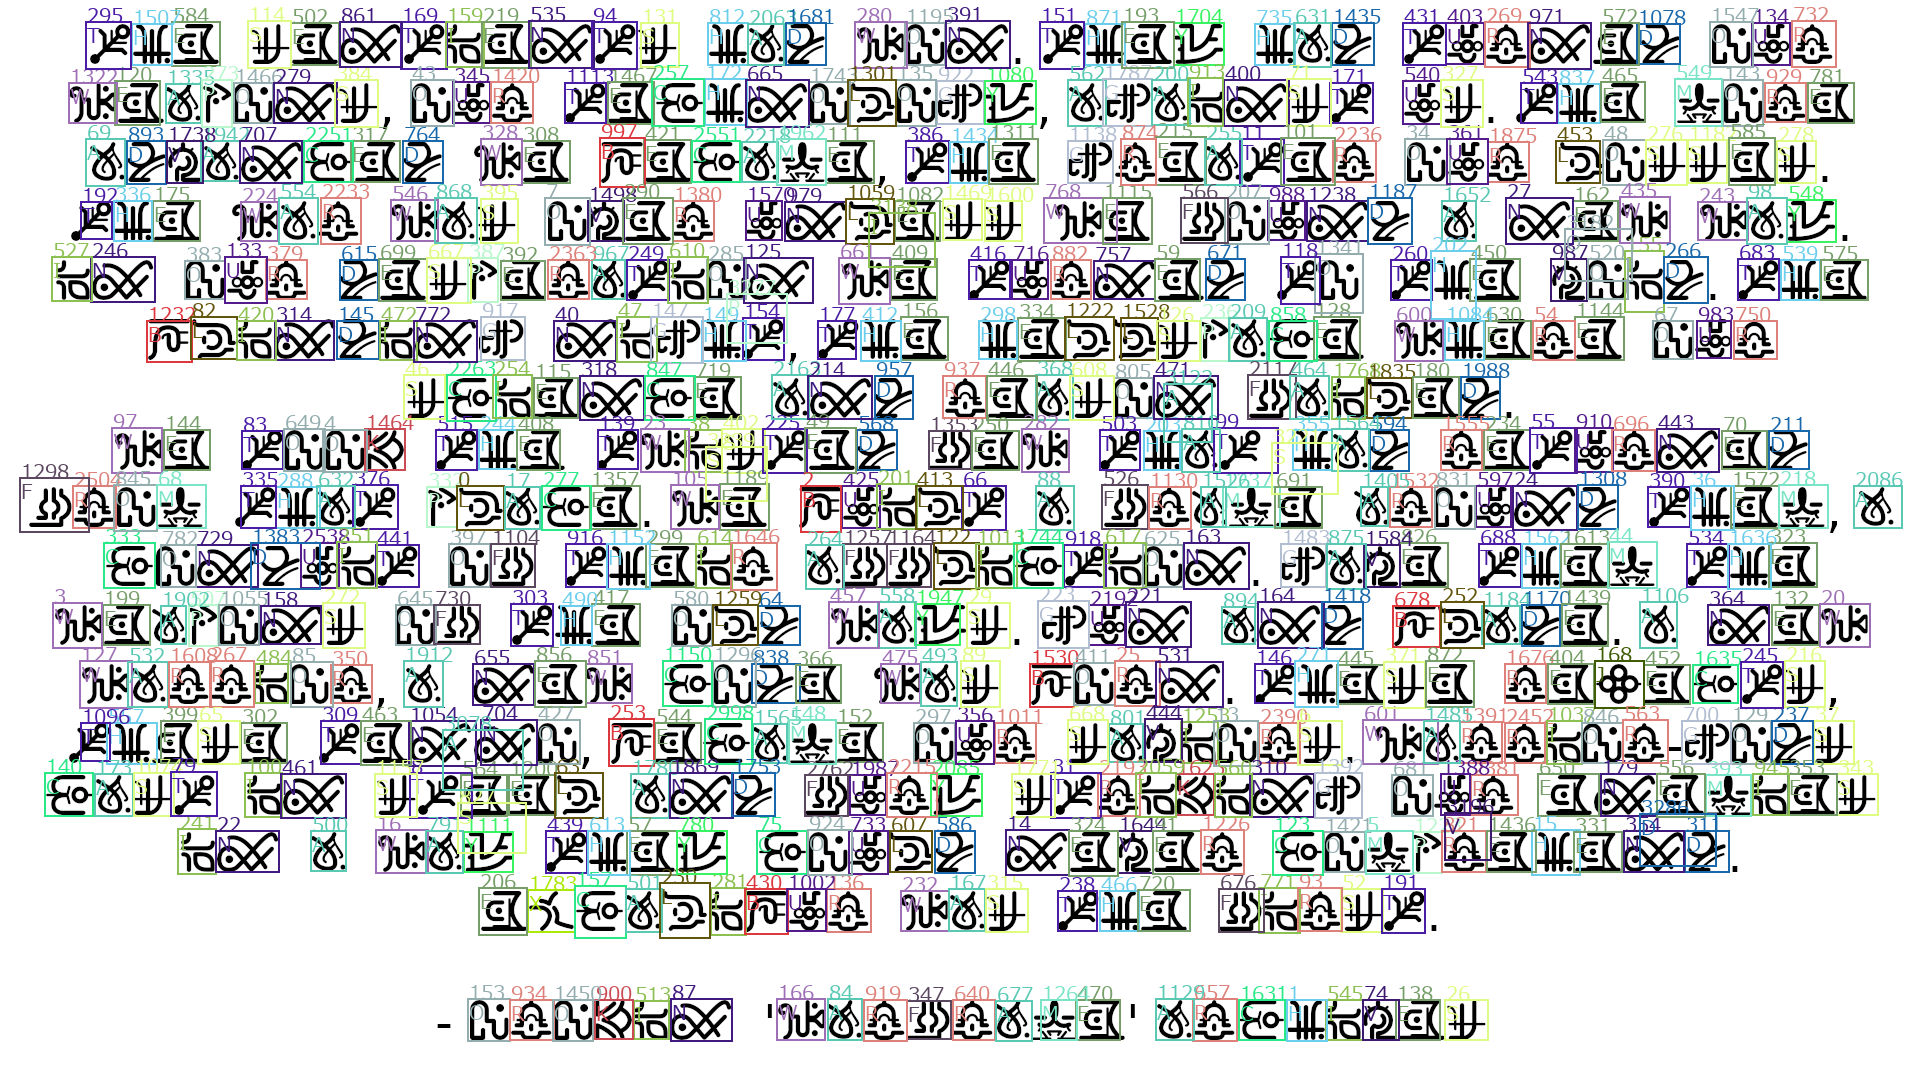

In [73]:
filterThreshold=0.95
mod_results = sortResults(full_results)
filterResults(mod_results,filterThreshold)
removeOverlapsTensors(mod_results)
levels = [i for i in range(len(mod_results['groups']))]
#levels = [0]
displayGroups(test_img, mod_results, levels, showBoxNumber=True)

_="""
for count, box in enumerate(mod_results['boxes']):
    strList = ["{0:0.1f}".format(f) for f in box.tolist()]
    print("{0}:{1}".format(count,strList))
"""

In [74]:
_="""
filterThreshold = 0.10

#print([level for level in full_results['groups']])

modStart=time.time()
mod_results = sortResults(full_results)
filterResults(mod_results,filterThreshold)
computeNeighbors(mod_results,full_dims)
resultsToLists(mod_results)
print("Delay : {0:1f}s".format(time.time()-modStart))

#print(len(mod_results['neighbors'][0]))
#print(sum([len(group) for group in mod_results['neighbors']]))
#removeOverlaps(mod_results)
"""

In [75]:
_="""
levels = [0,1,2]
displayGroups(test_img, mod_results, levels, showBoxNumber=True)
for neigh in mod_results['neighbors']:
    print(neigh)
"""

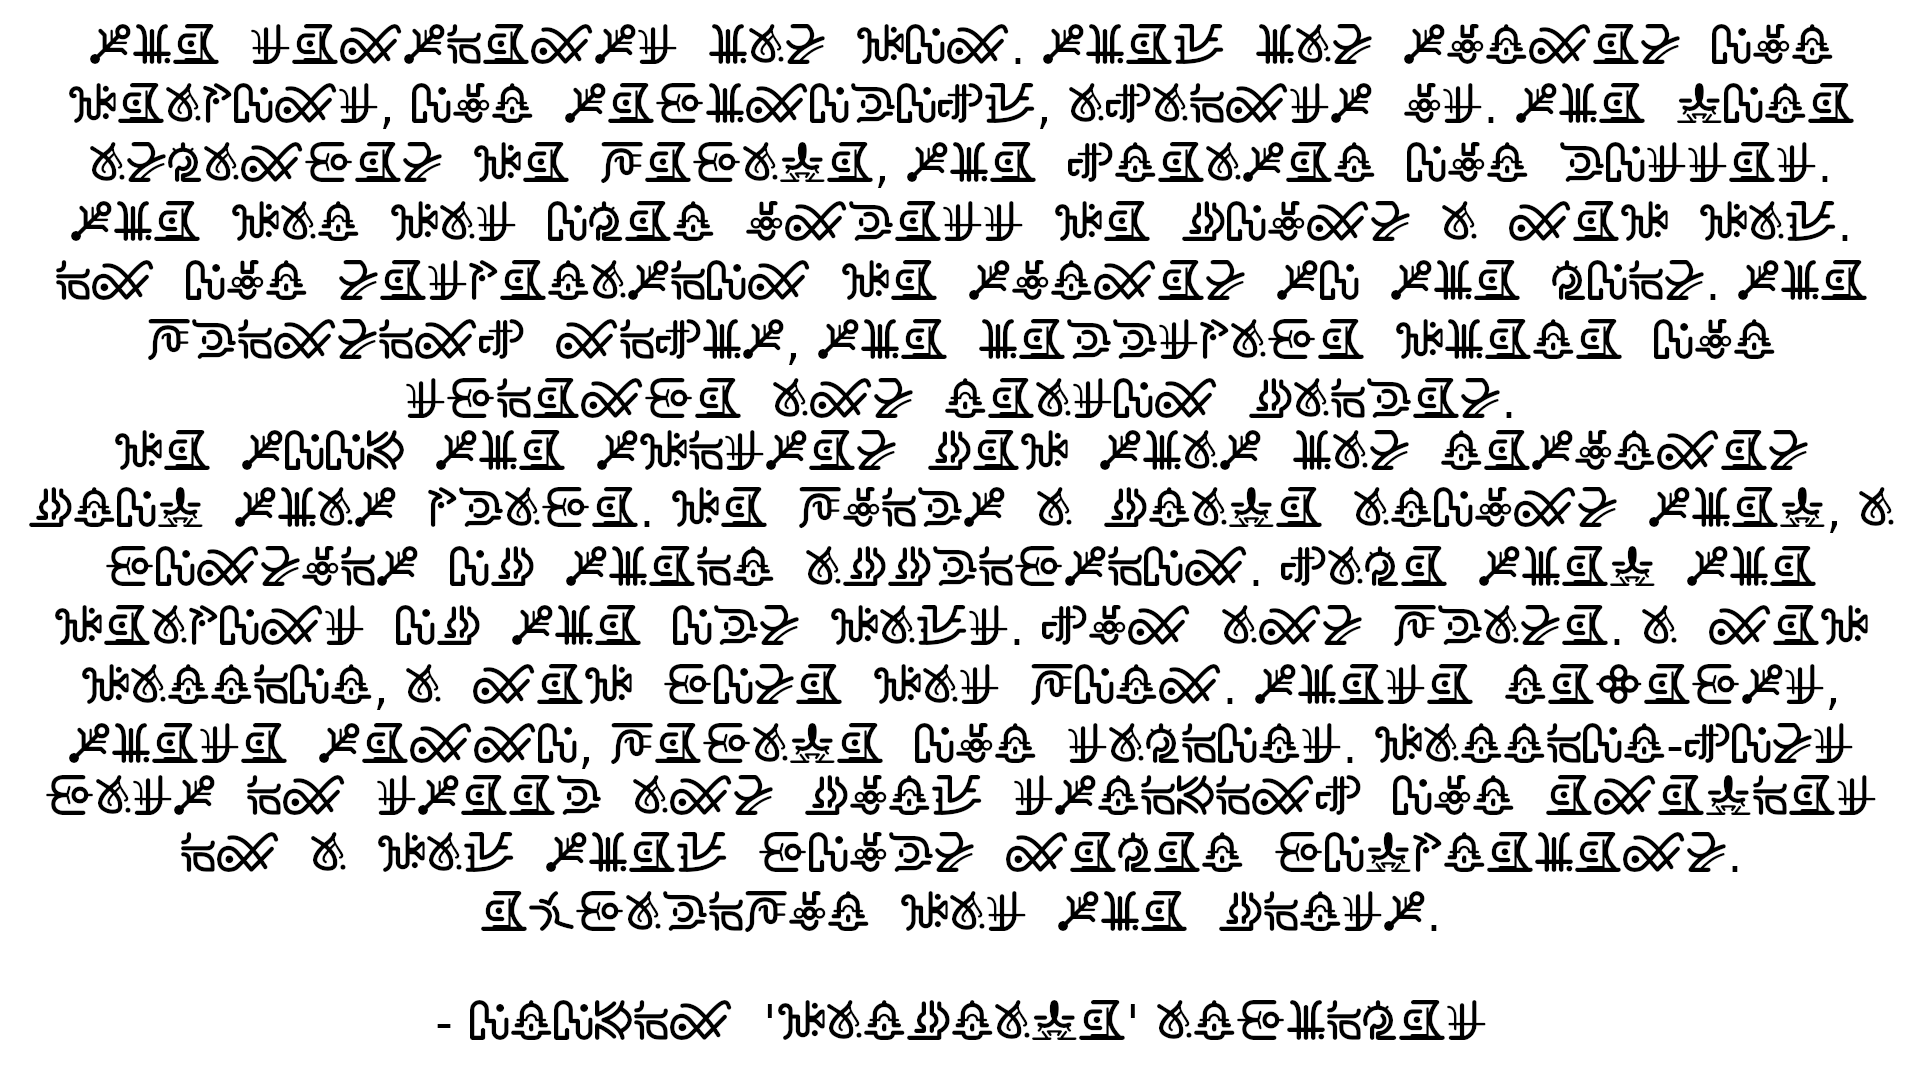

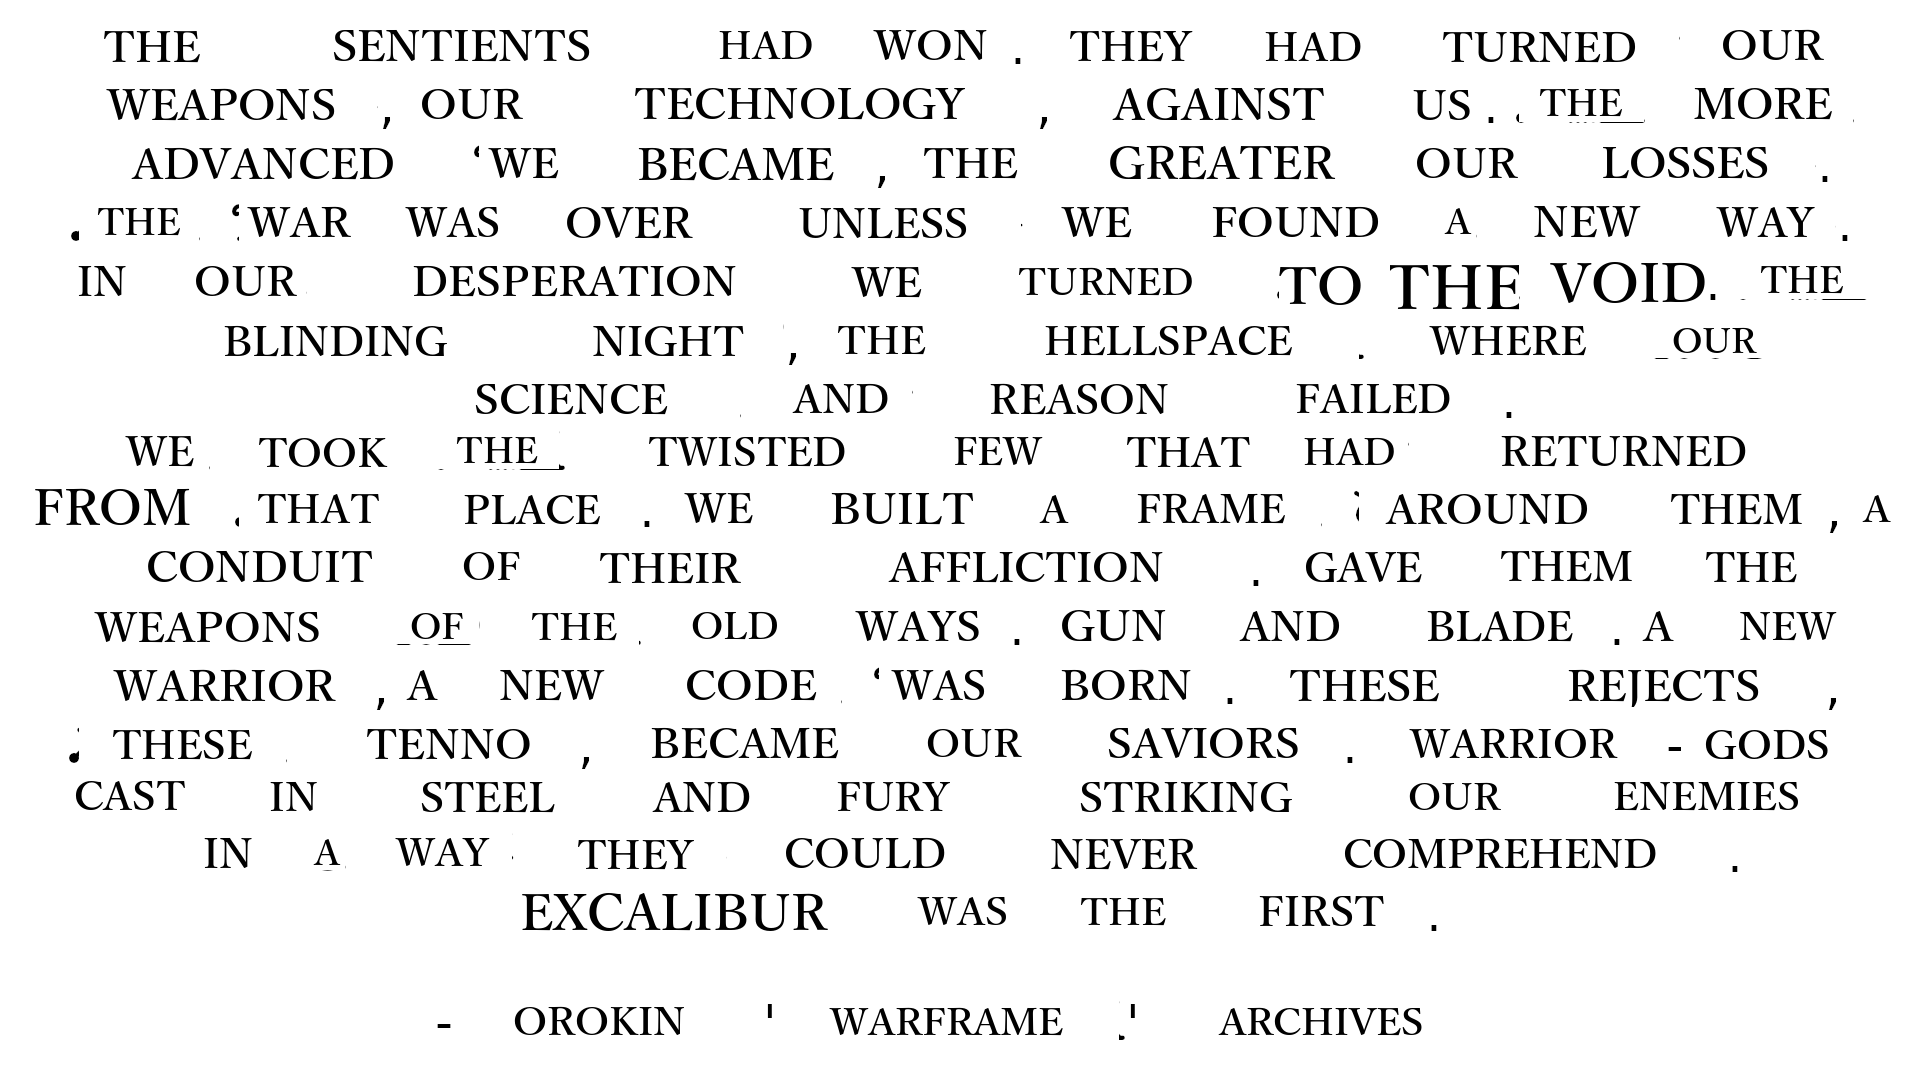

In [77]:
def computeWords(results):
    letterIndices = []
    for level in results['groups']:
        for group in level:
            letterIndices.extend([n for n in group])
    
    letterBoxes = results['boxes'][letterIndices]
    letterHeight = letterBoxes[:,3] - letterBoxes[:,1]
    
    centerLetterX = letterBoxes[:,[0,2]].mean(dim=1)
    centerLetterY = letterBoxes[:,[1,3]].mean(dim=1)
    letterCenters = torch.stack([centerLetterX, centerLetterY], dim=1)
    _,sortingHIndices = letterCenters[:,0].sort(dim=0)
    _,sortingVIndices = letterCenters[:,1].sort(dim=0)
    letterHeightV = letterHeight.gather(dim=0,index=sortingVIndices)
    sortedHLetters = torch.LongTensor(letterIndices).gather(dim=0,index=sortingHIndices)
    sortedVLetters = torch.LongTensor(letterIndices).gather(dim=0,index=sortingVIndices)
    letterCentersH = letterCenters.gather(dim=0,index=sortingHIndices.repeat(2,1).transpose(1,0))
    letterCentersV = letterCenters.gather(dim=0,index=sortingVIndices.repeat(2,1).transpose(1,0))
    
    letterToIndex = {  }
    
    letterCounter = 0
    lineCounter = 0
    lines = []
    linesY = []
    linesHeight = []
    alreadyPlaced = set()
    alreadyPlaced.add(letterCentersV[0])
    
    #print(sortedVLetters)
    #print(letterCentersV)
    #print(sortingVIndices)
    
    #Computes every box into lines of indices
    heightThresh = 0.2
    while letterCounter < letterCenters.size(0):
        
        firstLetterIndex = sortedVLetters[letterCounter].item()
        lines.append([firstLetterIndex])
        alreadyPlaced.add(firstLetterIndex)
        linesY.append(0)
        linesHeight.append(0)
        letterCounter+=1
        
        indicesLine= [i for i in range(letterCounter-len(lines[lineCounter]),letterCounter)]
        linesY[lineCounter] = letterCentersV[ indicesLine,1 ].mean().item()
        linesHeight[lineCounter] = letterHeightV[indicesLine].mean().item()
        
        while letterCounter<letterBoxes.size(0) and letterCentersV[letterCounter,1]-linesY[lineCounter] < linesHeight[lineCounter]*heightThresh:
            letterIndex = sortedVLetters[letterCounter].item()
            lines[lineCounter].append(letterIndex)
            alreadyPlaced.add(letterIndex)
            letterCounter+=1
            
            indicesLine= [i for i in range(letterCounter-len(lines[lineCounter]),letterCounter)]
            linesY[lineCounter] = letterCentersV[ indicesLine,1 ].mean().item()
            #linesHeight[lineCounter] = (letterBoxes[ lines[lineCounter],3 ] - letterBoxes[ lines[lineCounter],1 ] ).mean().item()
            linesHeight[lineCounter] = letterHeightV[indicesLine].mean().item()
        
        if letterCounter < letterCenters.size(0):
            lineCounter+=1
    
    #Remove annoying overlapping parasitic lines
    linesToDelete = set()
    lineOverlapThresh = 0.85
    for i in range(len(lines)):
        if i-1 in linesToDelete:
            continue
        
        if i>0 and  linesHeight[i] > (linesY[i]-linesY[i-1])/lineOverlapThresh < linesHeight[i-1]:
            #print(i)
            indexSmallerLine = min(i,i-1,key=(lambda a : len(lines[a])))
            linesToDelete.add(indexSmallerLine)
            
        if i+1<len(lines) and  linesHeight[i] > (linesY[i+1]-linesY[i])/lineOverlapThresh < linesHeight[i+1]:
            #print(i)
            indexSmallerLine = min(i,i+1,key=(lambda a : len(lines[a])))
            linesToDelete.add(indexSmallerLine)
            
    lines = [lines[n] for n in range(len(lines)) if n not in linesToDelete]
    
    #Separate lines into words
    #wordSeparationThresh = 1.5
    #wordClosenessThresh = 0.4
    wordSeparationThresh = 0.3
    #wordClosenessThresh = -0.7
    maxOverlap=0.5
    words = []
    wordsLength = []
    wordsHeight = []
    for i in range(len(lines)):
        lines[i].sort(key=(lambda a : results['boxes'][a,[0,2]].mean().item())) #Sort by position of their center
        
        avgLetterLength=0
        words.append([])
        for letter in lines[i]:
            
            if len(words[-1]) == 0:
                words[-1].append(letter)
                avgLetterLength = (results['boxes'][words[-1],2]-results['boxes'][words[-1],0]).mean().item()
            else:
                prevLetter = words[-1][-1]
                """
                centerX = results['boxes'][letter,[0,2]].mean().item()
                prevCenterX = results['boxes'][prevLetter,[0,2]].mean().item()
                isCloseEnough = centerX-prevCenterX < wordSeparationThresh*avgLetterLength
                isFarEnough = centerX-prevCenterX > wordClosenessThresh*avgLetterLength
                """
                """
                Xstart = results['boxes'][letter,0].item()
                prevXend = results['boxes'][prevLetter,2].item()
                isCloseEnough = Xstart-prevXend < wordSeparationThresh*avgLetterLength
                isFarEnough = Xstart-prevXend > wordClosenessThresh*avgLetterLength
                """
                Xstart,Xend = results['boxes'][letter,[0,2]].tolist()
                prevXstart,prevXend = results['boxes'][prevLetter,[0,2]].tolist()
                overlap = min(Xend,prevXend)-max(Xstart,prevXstart)
                proportionOverlap = min(overlap/(Xend-Xstart) , overlap/(prevXend-prevXstart))
                isCloseEnough = Xstart-prevXend < wordSeparationThresh*avgLetterLength
                isFarEnough = proportionOverlap < maxOverlap #Is far enough if the smallest proportional overlap of the 2 is small enough
                
                if isCloseEnough and isFarEnough:
                    words[-1].append(letter)
                    
                if not isCloseEnough and isFarEnough:
                    #wordsLength.append(avgLetterLength*len(words[-1]))
                    words.append([])
                    words[-1].append(letter)
                    
                if isCloseEnough and not isFarEnough: #if last letter and new letters are too close, only the most likely one is kept
                    words[-1].append(letter)
                    indexRemove = min(-1,-2,key=(lambda a : results['scores'][words[-1][a]]))
                    del words[-1][indexRemove]
                    
                    
            avgLetterLength = (results['boxes'][words[-1],2]-results['boxes'][words[-1],0]).mean().item()
        
    wordsLength = [(results['boxes'][letters,2].max()-results['boxes'][letters,0].min()).item() for letters in words]
    wordsHeight = [(results['boxes'][letters,3].max()-results['boxes'][letters,1].min()).item() for letters in words]
    wordsPosCenter = [ (results['boxes'][letters,:][:,[0,2]].mean().item() , results['boxes'][letters,:][:,[1,3]].mean().item()) for letters in words]
    wordsPos = [ (results['boxes'][letters,0].min().item() , results['boxes'][letters,1].min().item()) for letters in words]    
    
    validWordsForAtan = [
                            [letter for letter in words[i] if torch.abs(results['boxes'][letter,[0,2]].mean() - wordsPosCenter[i][0])>wordsLength[i]/(5*len(words[i]))]
                           for i in range(len(wordsPosCenter))]
    
    wordsAngle = [torch.atan2(
        results['boxes'][validWordsForAtan[wordI],:][:,[1,3]].mean(dim=1) - wordsPosCenter[wordI][1],
        torch.abs(results['boxes'][validWordsForAtan[wordI],:][:,[0,2]].mean(dim=1) - wordsPosCenter[wordI][0])
    ).mean().item() for wordI in range(len(words))] #OG
    
    wordsAngle = [(angle if angle==angle else 0) for angle in wordsAngle]
    wordsStr = ["".join([alphabet[results['labels'][letter]] for letter in word]) for word in words]
    
    """
    print(wordsStr)
    print(max(wordsAngle))
    print(max([i for i in range(len(wordsAngle))] ,key=(lambda a : wordsAngle[a])))
    print(validWordsForAtan)
    print(indexNaN)
    print(words)
    """
    wordsReturn = {
        "string":wordsStr,
        "pos":wordsPos,
        "width":wordsLength,
        "height":wordsHeight,
        "angle":wordsAngle,
        "indices":words
    }
    
    return wordsReturn

def drawWords(image,words):
    imageCopy = image.copy()
    draw = ImageDraw.Draw(imageCopy)
    
    for indexWord in range(len(words["string"])):
        

        coord = words['pos'][indexWord]
        w = words['width'][indexWord]
        h = words['height'][indexWord]
        stringWord = words['string'][indexWord]

        x1 = coord[0]
        y1 = coord[1]
        x2 = coord[0]+w
        y2 = coord[1]+h
        box = [x1,y1,x2,y2]
        center = (0.5*(x1+x2), 0.5*(y1+y2))
        angle = words['angle'][indexWord]
        box = rotateBox(box,angle,center)


        font=ImageFont.truetype("yumindb.ttf", int(h*0.9))
        _,_,textLength,textHeight = font.getbbox(stringWord)

        yOffset = font.size*0.10 #perk of the yumindb.ttf font
        #center2 = (center[0] , center[1]+yOffset)
        center2 = (w/2 , h/2+yOffset)

        backColor = (255,255,255,255)
        textColor = (0,0,0,255)
        wordPic = Image.new(mode='RGBA', size=(int(w),int(h)), color=backColor)
        draw2 = ImageDraw.Draw(wordPic)
        draw2.text(center2, stringWord, fill=textColor, anchor="mm", font=font)
        upperLeft = (int(box[0]),int(box[1]))
        imageCopy.paste(wordPic.copy(),box=upperLeft)
        
        
        #draw.rectangle(box, fill=(255,255,255))
        #draw.text(center2, stringWord, fill=textColor, anchor="mm", font=font)
        #draw.text((x1+2,y1-20), boxNumber, color, font=font)
        
    display(imageCopy)
    
words = computeWords(mod_results)
#displayLines(test_img, mod_results, words, indicesLines=[133], showBoxNumber=False)
#displayLines(test_img, mod_results, words["indices"], showBoxNumber=False)
display(test_img)
drawWords(test_img,words)